In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

from functions import *

In [2]:
df_t = pd.read_csv('../data/raw/training_Traffic.csv')
df_s = pd.read_csv('../data/raw/training_Sales.csv')

In [3]:
# increasing max length for all columns and rows
pd.set_option('display.max_colwidth', -1)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58437 entries, 0 to 58436
Data columns (total 2 columns):
Date     58437 non-null object
Value    58437 non-null int64
dtypes: int64(1), object(1)
memory usage: 913.2+ KB


In [5]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67058 entries, 0 to 67057
Data columns (total 2 columns):
Date     67058 non-null object
Value    67058 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
# convert date into datetime columns
df_t['Date'] = pd.to_datetime(df_t['Date'])
df_s['Date'] = pd.to_datetime(df_s['Date'])

In [7]:
# setting date as indexes
df_t.set_index('Date', inplace=True)
df_s.set_index('Date', inplace=True)

In [8]:
df_t.head(5)

,Value
Date,
2015-01-01 10:00:00,0
2015-01-01 10:15:00,1
2015-01-01 10:30:00,4
2015-01-01 10:45:00,3
2015-01-01 11:00:00,1


In [9]:
df_s.head(5)

,Value
Date,
2013-11-07 13:00:00,830
2013-11-07 13:15:00,885
2013-11-07 13:30:00,938
2013-11-07 13:45:00,804
2013-11-07 14:00:00,793


There are no missing values in the current datasets for the dates provided

In [10]:
# checking for missing values in traffic df
df_t.isna().sum()

Value    0
dtype: int64

In [11]:
# checking for missing values in sales df
df_s.isna().sum()

Value    0
dtype: int64

The datasets provided are too granular. Since we are interested only in predicting traffic and sales by the hour, it is possible to do some downsampling on the dates

In [12]:
# downsampling by the hour for all traffic datapoints
temp_hourly_traffic = df_t.resample('H')
df_t_h = temp_hourly_traffic.sum()

In [13]:
# downsampling by the hour for all sales datapoints
temp_hourly_sales = df_s.resample('H')
df_s_h = temp_hourly_sales.sum()

In [14]:
df_t_h.head()

,Value
Date,
2015-01-01 10:00:00,8
2015-01-01 11:00:00,14
2015-01-01 12:00:00,28
2015-01-01 13:00:00,33
2015-01-01 14:00:00,47


In [15]:
df_s_h.head(5)

,Value
Date,
2013-11-07 13:00:00,3457
2013-11-07 14:00:00,2250
2013-11-07 15:00:00,0
2013-11-07 16:00:00,729
2013-11-07 17:00:00,0


Double checking that there are no missing hours/dates

In [16]:
len(df_t_h)

29316

In [17]:
pd.period_range(start = df_t_h.index.min(), end = df_t_h.index.max(), freq = 'H')

PeriodIndex(['2015-01-01 10:00', '2015-01-01 11:00', '2015-01-01 12:00',
             '2015-01-01 13:00', '2015-01-01 14:00', '2015-01-01 15:00',
             '2015-01-01 16:00', '2015-01-01 17:00', '2015-01-01 18:00',
             '2015-01-01 19:00',
             ...
             '2018-05-06 12:00', '2018-05-06 13:00', '2018-05-06 14:00',
             '2018-05-06 15:00', '2018-05-06 16:00', '2018-05-06 17:00',
             '2018-05-06 18:00', '2018-05-06 19:00', '2018-05-06 20:00',
             '2018-05-06 21:00'],
            dtype='period[H]', length=29316, freq='H')

In [18]:
pd.period_range(start = '2015-01-01 10:00', end = '2018-05-06 21:00', freq='H')

PeriodIndex(['2015-01-01 10:00', '2015-01-01 11:00', '2015-01-01 12:00',
             '2015-01-01 13:00', '2015-01-01 14:00', '2015-01-01 15:00',
             '2015-01-01 16:00', '2015-01-01 17:00', '2015-01-01 18:00',
             '2015-01-01 19:00',
             ...
             '2018-05-06 12:00', '2018-05-06 13:00', '2018-05-06 14:00',
             '2018-05-06 15:00', '2018-05-06 16:00', '2018-05-06 17:00',
             '2018-05-06 18:00', '2018-05-06 19:00', '2018-05-06 20:00',
             '2018-05-06 21:00'],
            dtype='period[H]', length=29316, freq='H')

There are no missing hours for our traffic hourly dataframe

In [19]:
len(df_s_h)

39391

In [20]:
pd.period_range(start = df_s_h.index.min(), end = df_s_h.index.max(), freq = 'H')

PeriodIndex(['2013-11-07 13:00', '2013-11-07 14:00', '2013-11-07 15:00',
             '2013-11-07 16:00', '2013-11-07 17:00', '2013-11-07 18:00',
             '2013-11-07 19:00', '2013-11-07 20:00', '2013-11-07 21:00',
             '2013-11-07 22:00',
             ...
             '2018-05-06 10:00', '2018-05-06 11:00', '2018-05-06 12:00',
             '2018-05-06 13:00', '2018-05-06 14:00', '2018-05-06 15:00',
             '2018-05-06 16:00', '2018-05-06 17:00', '2018-05-06 18:00',
             '2018-05-06 19:00'],
            dtype='period[H]', length=39391, freq='H')

In [21]:
pd.period_range(start = '2013-11-07 13:00', end = '2018-05-06 19:00', freq='H')

PeriodIndex(['2013-11-07 13:00', '2013-11-07 14:00', '2013-11-07 15:00',
             '2013-11-07 16:00', '2013-11-07 17:00', '2013-11-07 18:00',
             '2013-11-07 19:00', '2013-11-07 20:00', '2013-11-07 21:00',
             '2013-11-07 22:00',
             ...
             '2018-05-06 10:00', '2018-05-06 11:00', '2018-05-06 12:00',
             '2018-05-06 13:00', '2018-05-06 14:00', '2018-05-06 15:00',
             '2018-05-06 16:00', '2018-05-06 17:00', '2018-05-06 18:00',
             '2018-05-06 19:00'],
            dtype='period[H]', length=39391, freq='H')

There are no missing hours for our sales hourly dataframe.

# Merging US Holidays External Dataset

In this section, the external dataset of all federal US holidays is uploaded and preprocessed.

In [22]:
df_us_hol = pd.read_csv('../data/raw/usholidays.csv')

In [23]:
df_us_hol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 3 columns):
Unnamed: 0    485 non-null int64
Date          485 non-null object
Holiday       485 non-null object
dtypes: int64(1), object(2)
memory usage: 11.5+ KB


In [24]:
df_us_hol.head()

,Unnamed: 0,Date,Holiday
0,0,2010-12-31,New Year's Day
1,1,2011-01-17,"Birthday of Martin Luther King, Jr."
2,2,2011-02-21,Washington's Birthday
3,3,2011-05-30,Memorial Day
4,4,2011-07-04,Independence Day


In the following lines, the series date is tranformed into a datetime series and also set as the index. The column 'unnamed:0' is also dropped as it is not relevant.

In [25]:
# converting the date from object type to datetime type
df_us_hol['Date'] = pd.to_datetime(df_us_hol['Date'], format = '%Y-%m-%d %H:%M')


In [26]:
df_us_hol.head()

,Unnamed: 0,Date,Holiday
0,0,2010-12-31,New Year's Day
1,1,2011-01-17,"Birthday of Martin Luther King, Jr."
2,2,2011-02-21,Washington's Birthday
3,3,2011-05-30,Memorial Day
4,4,2011-07-04,Independence Day


In [27]:
df_us_hol.set_index('Date', inplace = True)
df_us_hol.drop('Unnamed: 0', axis = 1, inplace=True)

There was a duplicate element in the column date

In [28]:
# isolating the duplicate value
df_us_hol[df_us_hol.index.duplicated()]

,Holiday
Date,
1989-11-11,Veterans Day


In [29]:
# removing duplicate from the column 
df_us_hol = df_us_hol[~df_us_hol.index.duplicated()]

In [30]:
# double checking that the duplicate is gone
df_us_hol[df_us_hol.index.duplicated()]

,Holiday
Date,


In [31]:
df_us_hol.index

DatetimeIndex(['2010-12-31', '2011-01-17', '2011-02-21', '2011-05-30',
               '2011-07-04', '2011-09-05', '2011-10-10', '2011-11-11',
               '2011-11-24', '2011-12-26',
               ...
               '1972-11-23', '1972-12-25', '1966-01-01', '1966-02-22',
               '1966-07-04', '1966-09-05', '1966-10-12', '1966-11-11',
               '1966-11-24', '1966-12-25'],
              dtype='datetime64[ns]', name='Date', length=484, freq=None)

The initial dataset contains Federal US Holidays spanning from 1966 to 2020. Only the range relevant to our traffic and sales df are necessary.

In [32]:
range_holidays_s = df_us_hol ['2013-11-07':'2018-05-06']
range_holidays_t = df_us_hol ['2015-01-01':'2018-05-06']

In [33]:
range_holidays_s.head()

,Holiday
Date,
2013-11-11,Veterans Day
2013-11-28,Thanksgiving Day
2013-12-25,Christmas Day
2014-01-01,New Year's Day
2014-01-20,"Birthday of Martin Luther King, Jr."


The final step is to merge both the traffic and sales dataframes with the 'range_holidays' one.
Also, I need to forward fill on all dates under the column holiday as the df 'range_holidays' only has days and not hours.
Ffill is set at limit 23 so that all the Nan hour values during Federal US holidays can be filled.  

In [34]:
df_s_hh = pd.concat([df_s_h, range_holidays_s ], axis = 1, join = 'outer')

In [35]:
df_s_hh['Holiday'] = df_s_hh ['Holiday'].ffill(limit = 23)

In [36]:
# random picking a US federal holiday to double check everything worked correctly
df_s_hh['2016-02-15']

,Value,Holiday
Date,,
2016-02-15 00:00:00,0,Washington's Birthday
2016-02-15 01:00:00,0,Washington's Birthday
2016-02-15 02:00:00,0,Washington's Birthday
2016-02-15 03:00:00,0,Washington's Birthday
2016-02-15 04:00:00,0,Washington's Birthday
2016-02-15 05:00:00,0,Washington's Birthday
2016-02-15 06:00:00,0,Washington's Birthday
2016-02-15 07:00:00,0,Washington's Birthday
2016-02-15 08:00:00,0,Washington's Birthday


Repeating the same merging procedure for the traffic dataframe

In [37]:
df_t_hh = pd.concat([df_t_h, range_holidays_t ], axis = 1, join = 'outer')

In [38]:
df_t_hh['Holiday'] = df_t_hh['Holiday'].ffill(limit = 23)

There is a mismatch with the initial dataset in terms of length. There's probably some missing values produced by mistake in the process. 

In [39]:
df_t_hh

,Value,Holiday
Date,,
2015-01-01 00:00:00,NaN,New Year's Day
2015-01-01 10:00:00,8.0,New Year's Day
2015-01-01 11:00:00,14.0,New Year's Day
2015-01-01 12:00:00,28.0,New Year's Day
2015-01-01 13:00:00,33.0,New Year's Day
...,...,...
2018-05-06 17:00:00,27.0,NaN
2018-05-06 18:00:00,14.0,NaN
2018-05-06 19:00:00,4.0,NaN


In [40]:
df_t_hh.isna().sum()

Value      1    
Holiday    28525
dtype: int64

Getting rid of the date "2015-01-01 00:00:00" as it was wrongly created by the merging of the two dfs.

In [41]:
df_t_hh = df_t_hh[1:]
df_t_hh

,Value,Holiday
Date,,
2015-01-01 10:00:00,8.0,New Year's Day
2015-01-01 11:00:00,14.0,New Year's Day
2015-01-01 12:00:00,28.0,New Year's Day
2015-01-01 13:00:00,33.0,New Year's Day
2015-01-01 14:00:00,47.0,New Year's Day
...,...,...
2018-05-06 17:00:00,27.0,NaN
2018-05-06 18:00:00,14.0,NaN
2018-05-06 19:00:00,4.0,NaN


In [42]:
len(df_t_hh)

29316

# EDA Visualisation

In [43]:
# building more detailed df for traffic
df_t_hh['time'] = df_t_hh.index.hour
df_t_hh['mdate'] = df_t_hh.index.day
df_t_hh['day'] = df_t_hh.index.dayofweek
df_t_hh['week'] = df_t_hh.index.weekofyear
df_t_hh['month'] = df_t_hh.index.month
df_t_hh['year'] = df_t_hh.index.year

In [44]:
# building more detailed df ofr sales
df_s_hh['time'] = df_s_hh.index.hour
df_s_hh['mdate'] = df_s_hh.index.day
df_s_hh['day'] = df_s_hh.index.dayofweek
df_s_hh['week'] = df_s_hh.index.weekofyear
df_s_hh['month'] = df_s_hh.index.month
df_s_hh['year'] = df_s_hh.index.year

# changing cents to dollars
df_s_hh['Value'] = df_s_hh['Value']/100

In [45]:
# Prepare traffic data for variation by hour of the day (total)
pivothour_t = pd.pivot_table(df_t_hh, values='Value', columns='day', index = 'time',
                             aggfunc=np.nanmean)



In [46]:
# Prepare sales data for variation by hour of the day (total)
pivothour_s = pd.pivot_table(df_s_hh, values='Value', columns='day', index = 'time',
                             aggfunc=np.nanmean)



In [47]:
# Average traffic per month over the years
pivotmonth_t = pd.pivot_table(df_t_hh.replace(0, np.nan), values='Value', columns='year', index = 'month',
                             aggfunc=np.mean)

In [48]:
# total sales sum per month over the years
pivotmonth_s = pd.pivot_table(df_s_hh.replace(0, np.nan), values='Value', columns='year', index = 'month',
                             aggfunc=np.sum)


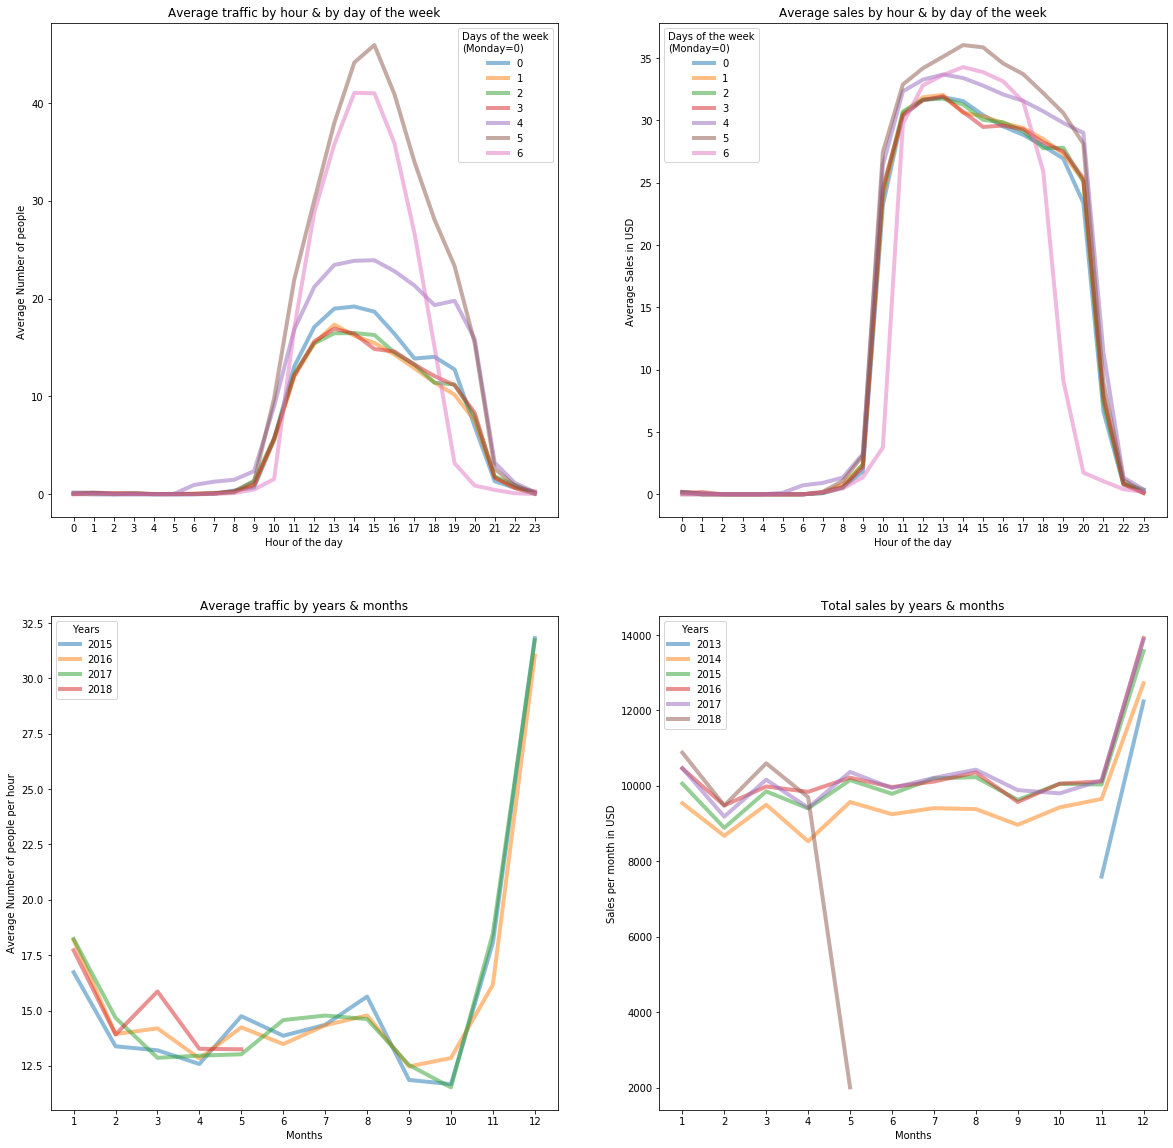

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,20))

ax[0,0].plot(pivothour_t, linewidth=4, alpha=0.5)
ax[0,0].set_title('Average traffic by hour & by day of the week')
ax[0,0].set_ylabel('Average Number of people ')
ax[0,0].set_xlabel('Hour of the day')
ax[0,0].set_xticks(range(0,24))
ax[0,0].legend(pivothour_t.columns.values, title='Days of the week\n(Monday=0)')

ax[0,1].plot(pivothour_s, linewidth=4, alpha=0.5)
ax[0,1].set_title('Average sales by hour & by day of the week')
ax[0,1].set_ylabel('Average Sales in USD ')
ax[0,1].set_xlabel('Hour of the day')
ax[0,1].set_xticks(range(0,24))
ax[0,1].legend(pivothour_s.columns.values, title='Days of the week\n(Monday=0)')

ax[1,0].plot(pivotmonth_t, linewidth=4, alpha=0.5)
ax[1,0].set_title('Average traffic by years & months')
ax[1,0].set_ylabel('Average Number of people per hour')
ax[1,0].set_xlabel('Months')
ax[1,0].set_xticks(range(1,13))
ax[1,0].legend(pivotmonth_t.columns.values, title='Years')

ax[1,1].plot(pivotmonth_s, linewidth=4, alpha=0.5)
ax[1,1].set_title('Total sales by years & months')
ax[1,1].set_ylabel('Sales per month in USD')
ax[1,1].set_xlabel('Months')
ax[1,1].set_xticks(range(1,13))
ax[1,1].legend(pivotmonth_s.columns.values, title='Years')
plt.show()

## What holidays are the busiest and most profitable ones?

### Traffic 

In [50]:
# creating a df only made of national holidays and weekends
df_holidays_traffic = df_t_hh.loc[(df_t_hh['day']>= 5)|(df_t_hh['Holiday'].notnull())]


In [51]:
df_holidays_traffic.loc[df_holidays_traffic['day'] == 5, 'Holiday'] = "Saturday"
df_holidays_traffic.loc[df_holidays_traffic['day'] == 6, 'Holiday'] = "Sunday"

In [52]:
df_holidays_traffic.head(15)

,Value,Holiday,time,mdate,day,week,month,year
Date,,,,,,,,
2015-01-01 10:00:00,8.0,New Year's Day,10,1,3,1,1,2015
2015-01-01 11:00:00,14.0,New Year's Day,11,1,3,1,1,2015
2015-01-01 12:00:00,28.0,New Year's Day,12,1,3,1,1,2015
2015-01-01 13:00:00,33.0,New Year's Day,13,1,3,1,1,2015
2015-01-01 14:00:00,47.0,New Year's Day,14,1,3,1,1,2015
2015-01-01 15:00:00,49.0,New Year's Day,15,1,3,1,1,2015
2015-01-01 16:00:00,48.0,New Year's Day,16,1,3,1,1,2015
2015-01-01 17:00:00,43.0,New Year's Day,17,1,3,1,1,2015
2015-01-01 18:00:00,28.0,New Year's Day,18,1,3,1,1,2015


In [53]:
df_holidays_traffic['Holiday'].isna().sum()

0

In [54]:
pivothour_holidays_traffic = pd.pivot_table(df_holidays_traffic, values='Value', columns='Holiday', index = 'time',
                             aggfunc=np.nanmean)


In [55]:
pivothour_holidays_traffic

Holiday,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Labor Day,Memorial Day,New Year's Day,Saturday,Sunday,Thanksgiving Day,Veterans Day,Washington's Birthday
time,,,,,,,,,,,,
0,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085714,0.011429,0.333333,0.333333,0.00
1,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.666667,0.000000,0.00
2,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017143,0.000000,3.333333,0.333333,0.00
3,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068571,0.000000,0.000000,0.333333,0.00
4,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017143,0.000000,0.333333,0.333333,0.00
5,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011429,0.000000,0.666667,0.000000,0.00
6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034286,0.011429,0.000000,0.000000,0.00
7,0.00,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.062857,0.034286,0.000000,0.000000,0.00
8,0.00,6.666667,0.333333,0.000000,0.666667,1.000000,0.750000,0.320000,0.125714,0.000000,0.000000,0.00


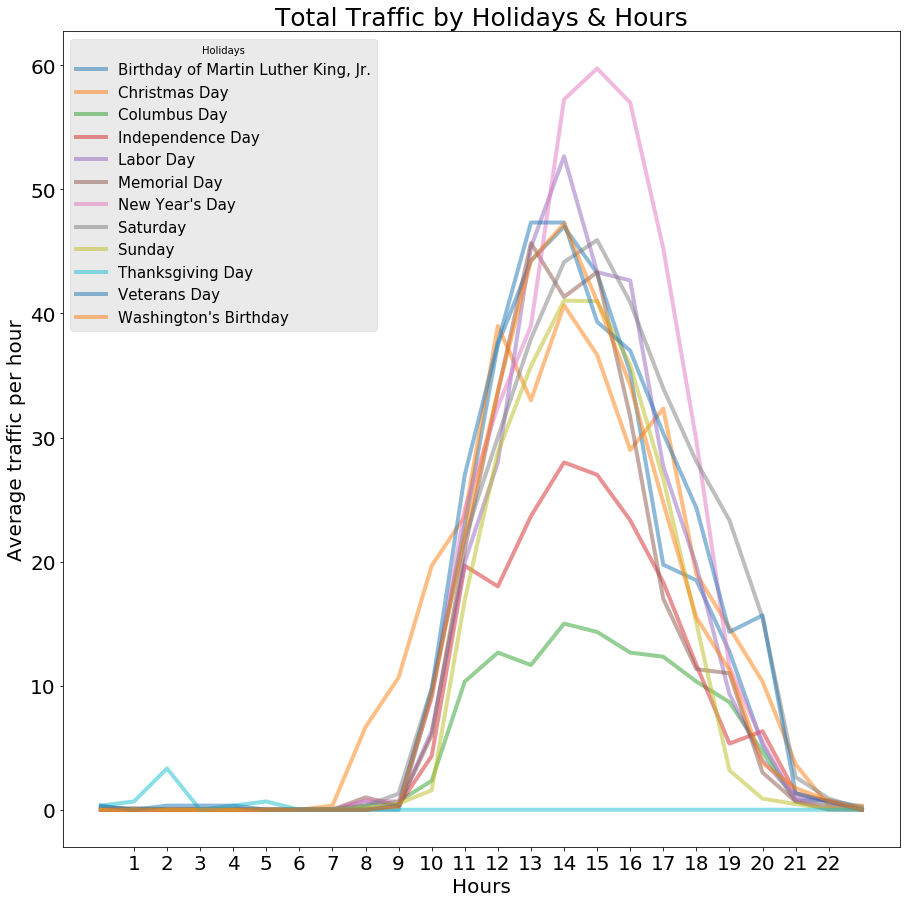

In [56]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15,15))

plt.style.use('ggplot')
ax.plot(pivothour_holidays_traffic, linewidth=4, alpha=0.5)
ax.set_title('Total Traffic by Holidays & Hours', fontsize = 25)
ax.set_ylabel('Average traffic per hour', fontsize= 20)
ax.set_xlabel('Hours', fontsize = 20)
ax.set_xticks(range(1,23))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(pivothour_holidays_traffic.columns.values, title='Holidays', fontsize=15)
plt.show()

### Sales

In [57]:
# creating a df only made of national holidays and weekends
df_holidays_sales = df_s_hh.loc[(df_s_hh['day']>= 5)|(df_s_hh['Holiday'].notnull())]


In [58]:
df_holidays_sales.loc[df_holidays_sales['day'] == 5, 'Holiday'] = "Saturday"
df_holidays_sales.loc[df_holidays_sales['day'] == 6, 'Holiday'] = "Sunday"

In [59]:
df_holidays_sales['Holiday'].isna().sum()

0

In [60]:
pivothour_holidays_sales = pd.pivot_table(df_holidays_sales, values='Value', columns='Holiday', index = 'time',
                             aggfunc=np.nanmean)


In [61]:
pivothour_holidays_sales

Holiday,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Labor Day,Memorial Day,New Year's Day,Saturday,Sunday,Thanksgiving Day,Veterans Day,Washington's Birthday
time,,,,,,,,,,,,
0,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
1,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
2,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
3,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
4,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
5,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
6,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.000000,0.000000,0.0,0.000,0.000
7,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.199702,0.135915,0.0,0.000,0.000
8,0.000,6.546,0.0000,0.0000,0.0000,0.0000,0.000,1.076553,0.465702,0.0,0.000,0.000


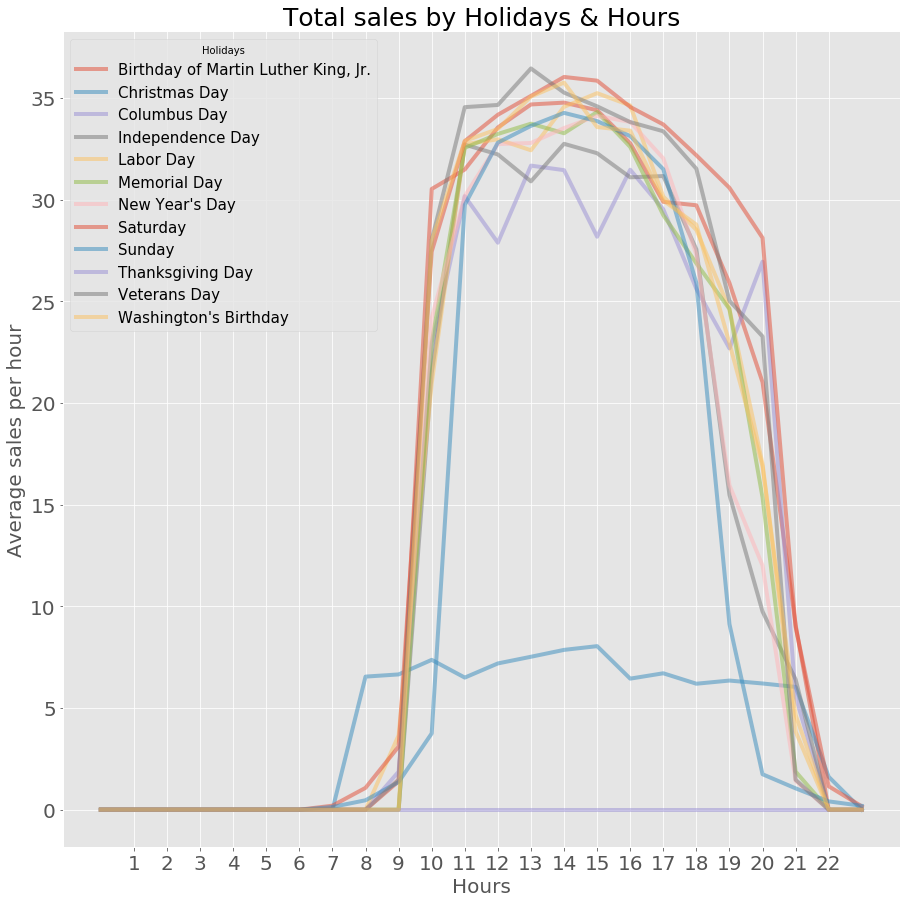

In [62]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15,15))

plt.style.use('ggplot')
ax.plot(pivothour_holidays_sales, linewidth=4, alpha=0.5)
ax.set_title('Total sales by Holidays & Hours', fontsize = 25)
ax.set_ylabel('Average sales per hour', fontsize= 20)
ax.set_xlabel('Hours', fontsize = 20)
ax.set_xticks(range(1,23))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(pivothour_holidays_sales.columns.values, title='Holidays', fontsize=15)
plt.show()

# Time Series Decomposition and Checking For Stationarity

Given the granularity of our dataset, it's quite hard to come up with any meaningful observations.
However, it is fair to say that **there is not a very significant trend** in neither dataset while there are clear signs of **seasonality**.

At the same time, by zooming in on the data it is also possible to detect some intra-seasonal patterns which are expected since this shop is not open 24/7.


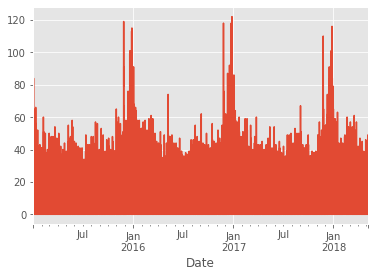

In [63]:
df_t_hh['Value'].plot()
plt.show()

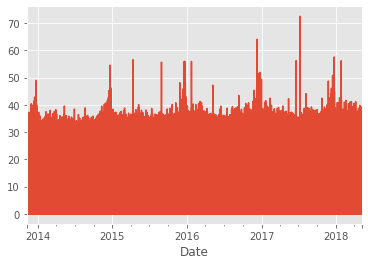

In [64]:
df_s_hh['Value'].plot()
plt.show()

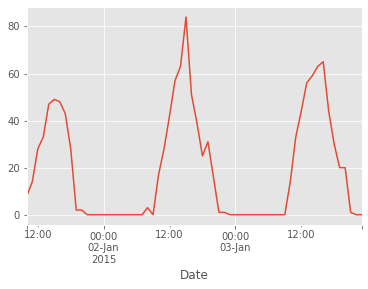

In [65]:
zoom_in_traffic = df_t_hh['2015-01-01':'2015-01-03']
zoom_in_traffic['Value'].plot()
plt.show()

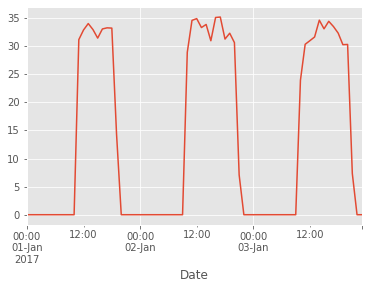

In [66]:
zoom_in_sales = df_s_hh['2017-01-01':'2017-01-03']
zoom_in_sales['Value'].plot()
plt.show()

At this point, time series decomposition is necessary in order to clearly separate overall trend from seasonality and residuals. The model is set to default to 'additive'.

## Traffic Decomposition

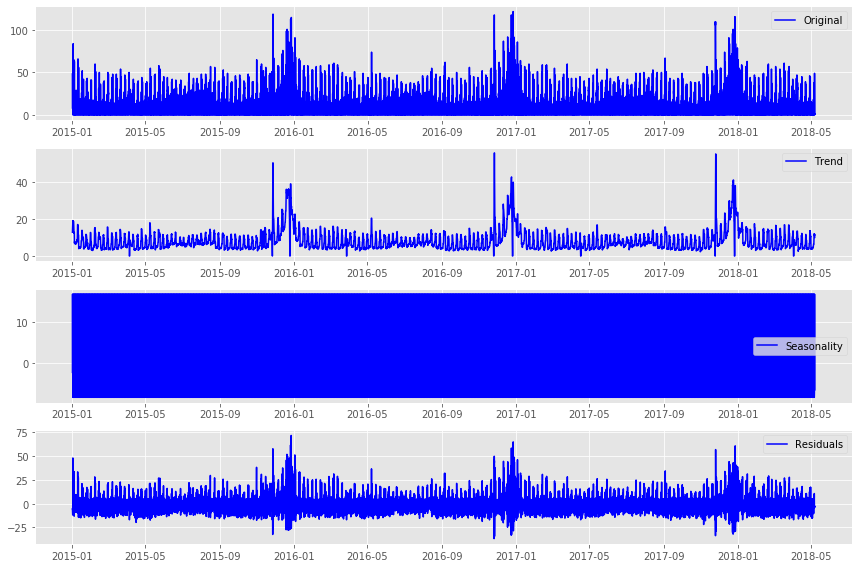

In [67]:
decomposition = seasonal_decompose(df_t_hh['Value'])

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_t_hh['Value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

## Sales Decomposition

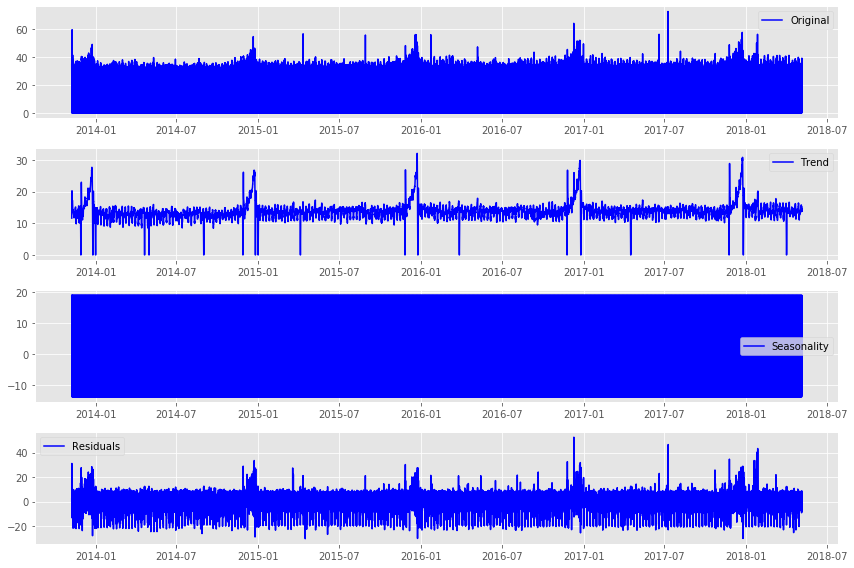

In [68]:
decomposition = seasonal_decompose(df_s_hh['Value'])

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_s_hh['Value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

## Dickey-Fuller test to check for stationarity

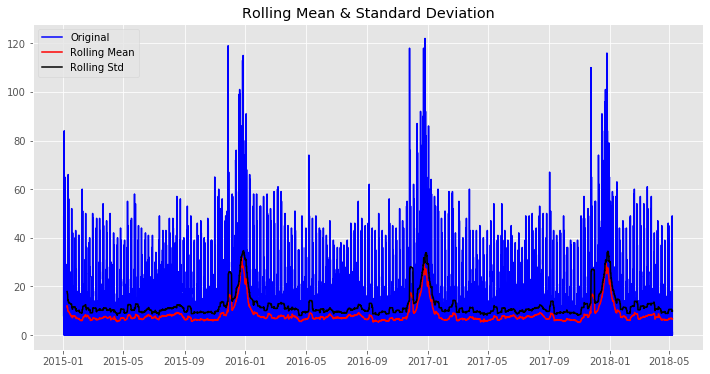

Results of Dickey-Fuller Test: 

Test Statistic                -1.487671e+01
p-value                        1.632388e-27
#Lags Used                     5.000000e+01
Number of Observations Used    2.926500e+04
Critical Value (1%)           -3.430573e+00
Critical Value (5%)           -2.861639e+00
Critical Value (10%)          -2.566823e+00
dtype: float64


In [69]:
stationarity_check(df_t_hh['Value'])


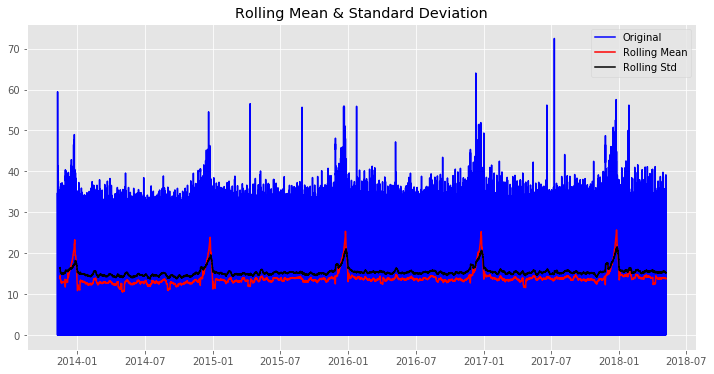

Results of Dickey-Fuller Test: 

Test Statistic                -1.816261e+01
p-value                        2.459015e-30
#Lags Used                     5.300000e+01
Number of Observations Used    3.933700e+04
Critical Value (1%)           -3.430516e+00
Critical Value (5%)           -2.861613e+00
Critical Value (10%)          -2.566809e+00
dtype: float64


In [70]:
stationarity_check(df_s_hh['Value'])


The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. So it seems reasonable to assume this time series is stationary for both datasets .

# Saving Processed Dataframes

In [71]:
df_t_hh

,Value,Holiday,time,mdate,day,week,month,year
Date,,,,,,,,
2015-01-01 10:00:00,8.0,New Year's Day,10,1,3,1,1,2015
2015-01-01 11:00:00,14.0,New Year's Day,11,1,3,1,1,2015
2015-01-01 12:00:00,28.0,New Year's Day,12,1,3,1,1,2015
2015-01-01 13:00:00,33.0,New Year's Day,13,1,3,1,1,2015
2015-01-01 14:00:00,47.0,New Year's Day,14,1,3,1,1,2015
...,...,...,...,...,...,...,...,...
2018-05-06 17:00:00,27.0,NaN,17,6,6,18,5,2018
2018-05-06 18:00:00,14.0,NaN,18,6,6,18,5,2018
2018-05-06 19:00:00,4.0,NaN,19,6,6,18,5,2018


In [72]:
df_t_hh.index = df_t_hh.index.strftime('%Y-%m-%d %H:%M')

In [73]:
df_t_hh.reset_index(inplace=True)
df_t_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29316 entries, 0 to 29315
Data columns (total 9 columns):
index      29316 non-null object
Value      29316 non-null float64
Holiday    791 non-null object
time       29316 non-null int64
mdate      29316 non-null int64
day        29316 non-null int64
week       29316 non-null int64
month      29316 non-null int64
year       29316 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 2.0+ MB


In [74]:
df_s_hh.index = df_s_hh.index.strftime('%Y-%m-%d %H:%M')

In [75]:
df_s_hh.reset_index(inplace=True)
df_s_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39391 entries, 0 to 39390
Data columns (total 9 columns):
index      39391 non-null object
Value      39391 non-null float64
Holiday    1104 non-null object
time       39391 non-null int64
mdate      39391 non-null int64
day        39391 non-null int64
week       39391 non-null int64
month      39391 non-null int64
year       39391 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 2.7+ MB


In [76]:
# saving traffic datasets for modelling
df_t_hh.to_csv('../data/processed/traffic_for_modelling.csv', index = False, date_format='%Y-%m-%d %H:%M:%S')

In [77]:
# saving sales datasets for modelling
df_s_hh.to_csv('../data/processed/sales_for_modelling.csv', index = False)